# `GWBSensitivity and DeterSensitivity` Tutorial
This tutorial is an introduction to the `sensitivity` module of the pulsar timing array sensitivity curve package `hasasia`. For an introduction to  sensitivity sky maps see later tutorials. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os,sys
import astropy.units as u
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('Research')
top_directory = "/".join(splt_path[0:top_path_idx+1])
top_directory += '/hasasia'

sys.path.insert(0,top_directory)
import hasasia
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

After importing various useful packages, including the needed `hasasia` submodules, and setting some `matplotlib` preferences, we instantiate 34 pulsar positions and timespans.

In [5]:
phi = np.random.uniform(0, 2*np.pi,size=34)
cos_theta = np.random.uniform(-1,1,size=34)
#This ensures a uniform distribution across the sky.
theta = np.arccos(cos_theta)

In [6]:
timespan=[11.4 for ii in range(10)]
timespan.extend([3.0 for ii in range(24)])

The simplest way to build a sensitivity curve is to use the `hasasia.sim` module to make a list of `hasasia.sensitivity.Pulsar` objects. One can use single values, a list/array of values or a mix for the parameters.

In [7]:
psrs = hsim.sim_pta(timespan=timespan, cad=23, sigma=1e-7,
                    phi=phi,theta=theta)

If red (time-correlated) noise is desired for the pulsars then one first needs to define a frequency array (in [Hz]) overwhich to calculate the red noise spectrum.

In [8]:
freqs = np.logspace(np.log10(5e-10),np.log10(5e-7),500)

In [9]:
psrs2 = hsim.sim_pta(timespan=timespan,cad=23,sigma=1e-7,
                     phi=phi,theta=theta,
                     A_rn=6e-16,alpha=-2/3.,freqs=freqs)

These lists of pulsars are then used to make a set of `hasasia.sensitivity.Spectrum` objects. These objects either build an array of frequencies, or alternatively take an array of frequencies, over which to calculate the various spectra. 

All frequency arras need to match across spectra and red noise realizations. 

In [10]:
spectra = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)        
    sp.NcalInv
    spectra.append(sp)

In [11]:
spectra2 = []
for p in psrs2:
    sp = hsen.Spectrum(p, freqs=freqs)        
    sp.NcalInv
    spectra2.append(sp)

Each spectra contains a number of attributes for that particular pulsar, including the inverse-noise-weighted transmission function, and sensitivity curve.

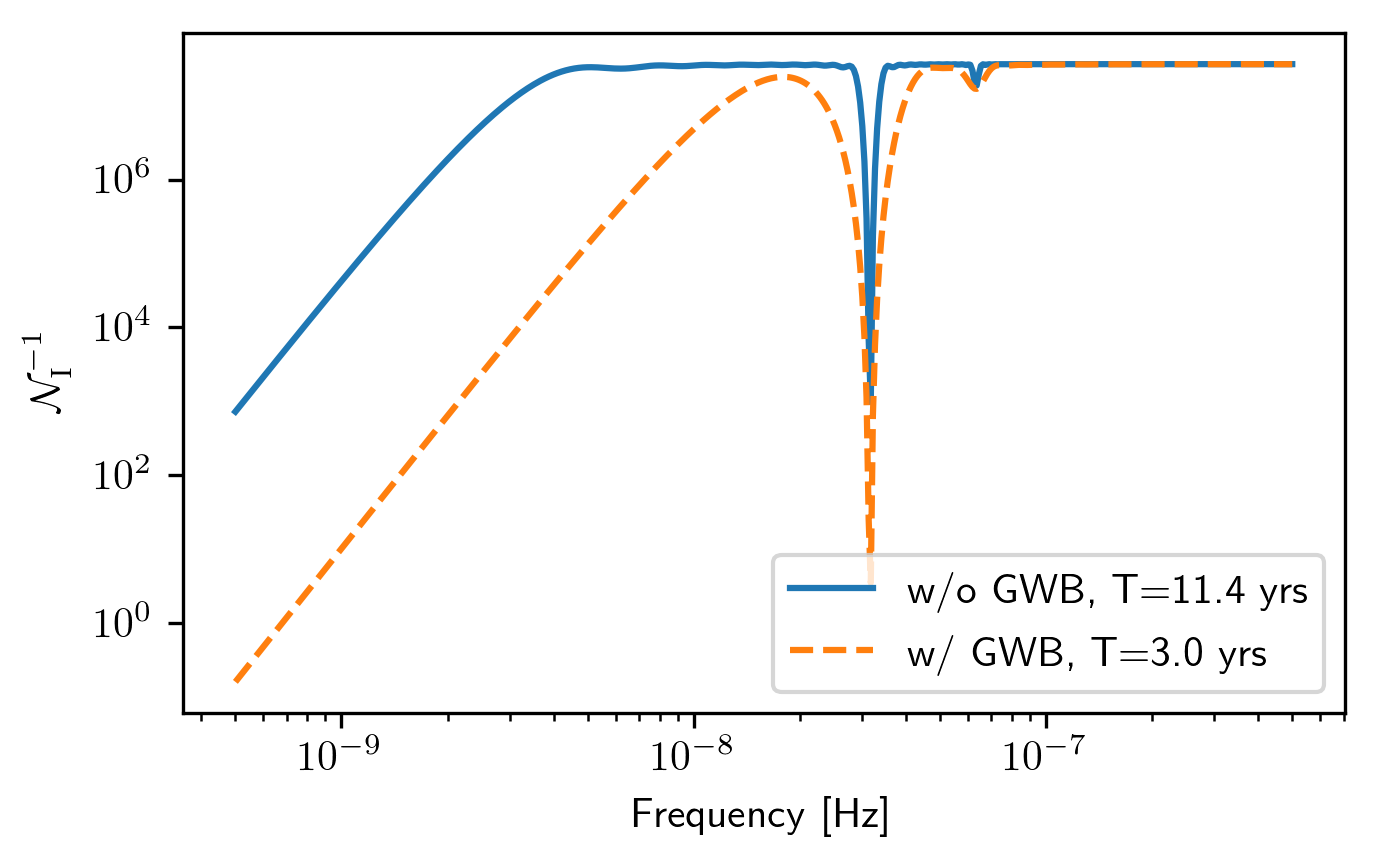

In [12]:
plt.loglog(spectra[0].freqs,spectra[0].NcalInv,
           label='w/o GWB, T={0} yrs'.format(timespan[0]))
plt.loglog(spectra2[20].freqs,spectra2[20].NcalInv,'--',
           label='w/ GWB, T={0} yrs'.format(timespan[20]))
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\mathcal{N}^{-1}_{\rm I}$')
plt.legend()
plt.show()

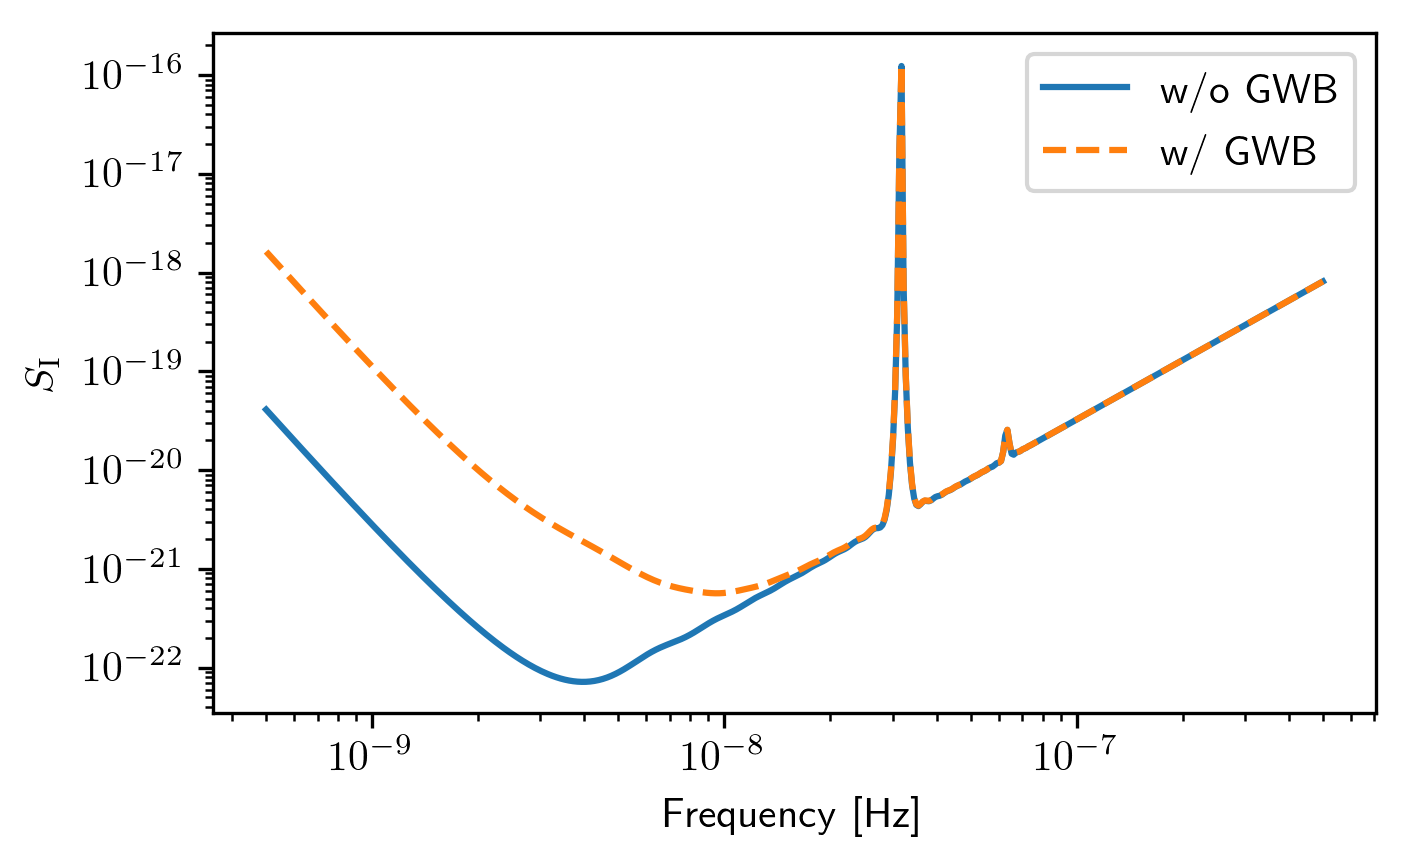

In [13]:
plt.loglog(spectra[0].freqs,spectra[0].S_I,label='w/o GWB')
plt.loglog(spectra2[0].freqs,spectra2[0].S_I,'--',label='w/ GWB')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_{\rm I}$')
plt.legend()
plt.show()

## Senstivity Curves
The list of spectra are then the input for the sensitivity curve classes.

In [14]:
sc1a = hsen.GWBSensitivityCurve(spectra)
sc1b = hsen.DeterSensitivityCurve(spectra)
sc2a = hsen.GWBSensitivityCurve(spectra2)
sc2b = hsen.DeterSensitivityCurve(spectra2)

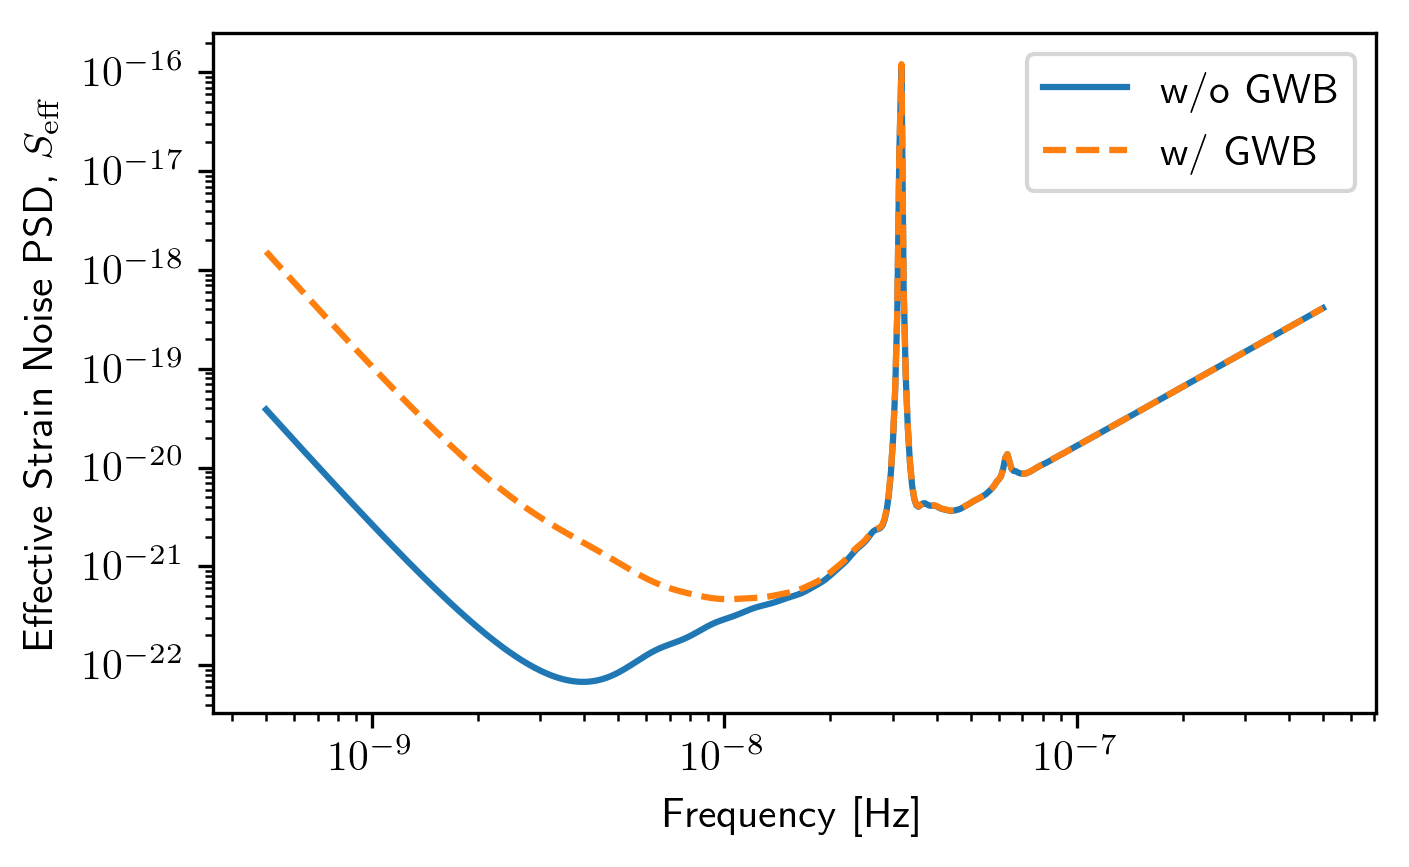

In [15]:
plt.loglog(sc1a.freqs,sc1a.S_eff,label='w/o GWB')
plt.loglog(sc2a.freqs,sc2a.S_eff,'--',label='w/ GWB')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.legend()
plt.show()

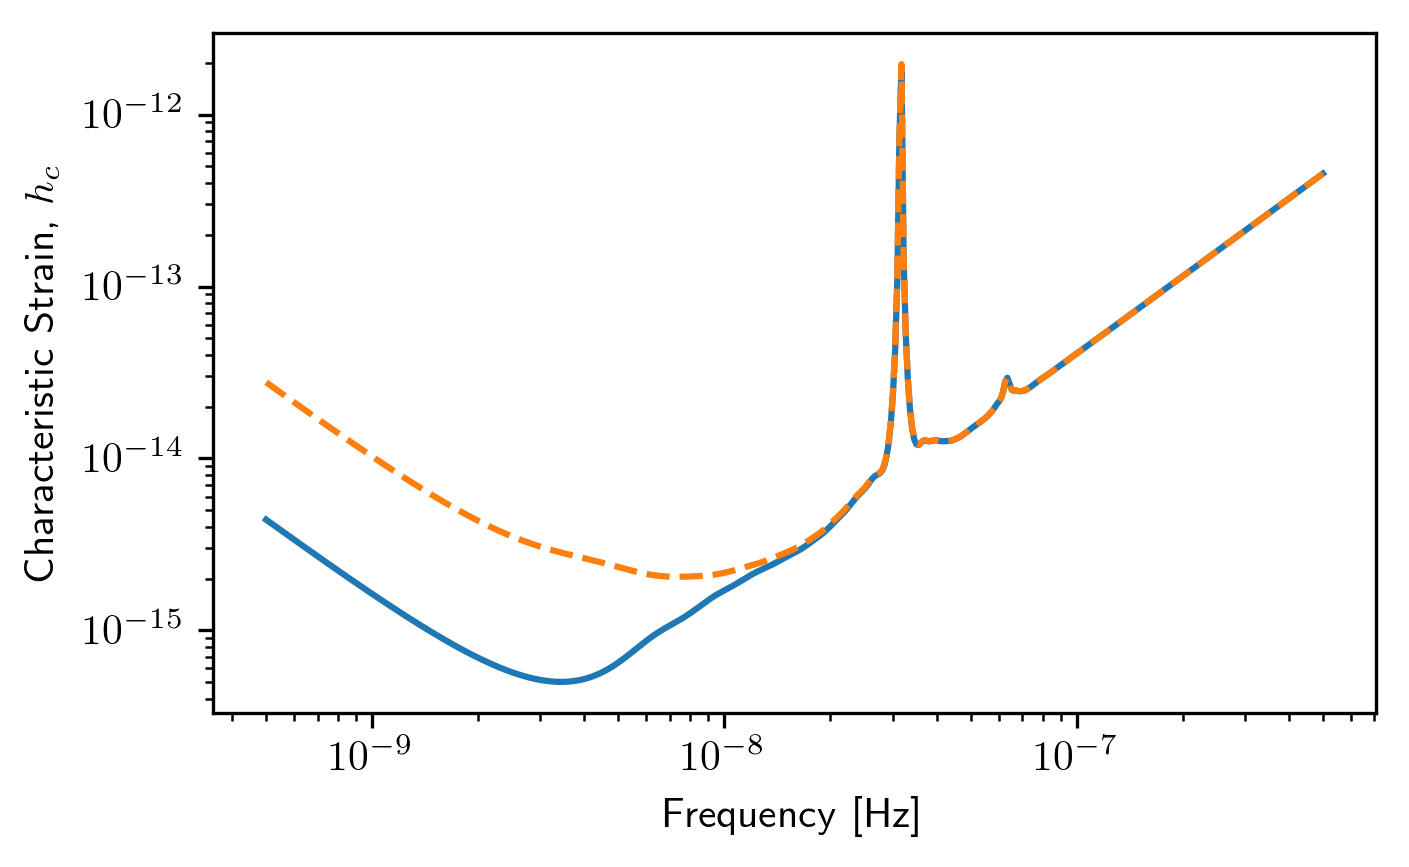

In [16]:
plt.loglog(sc1a.freqs,sc1a.h_c)
plt.loglog(sc2a.freqs,sc2a.h_c,'--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

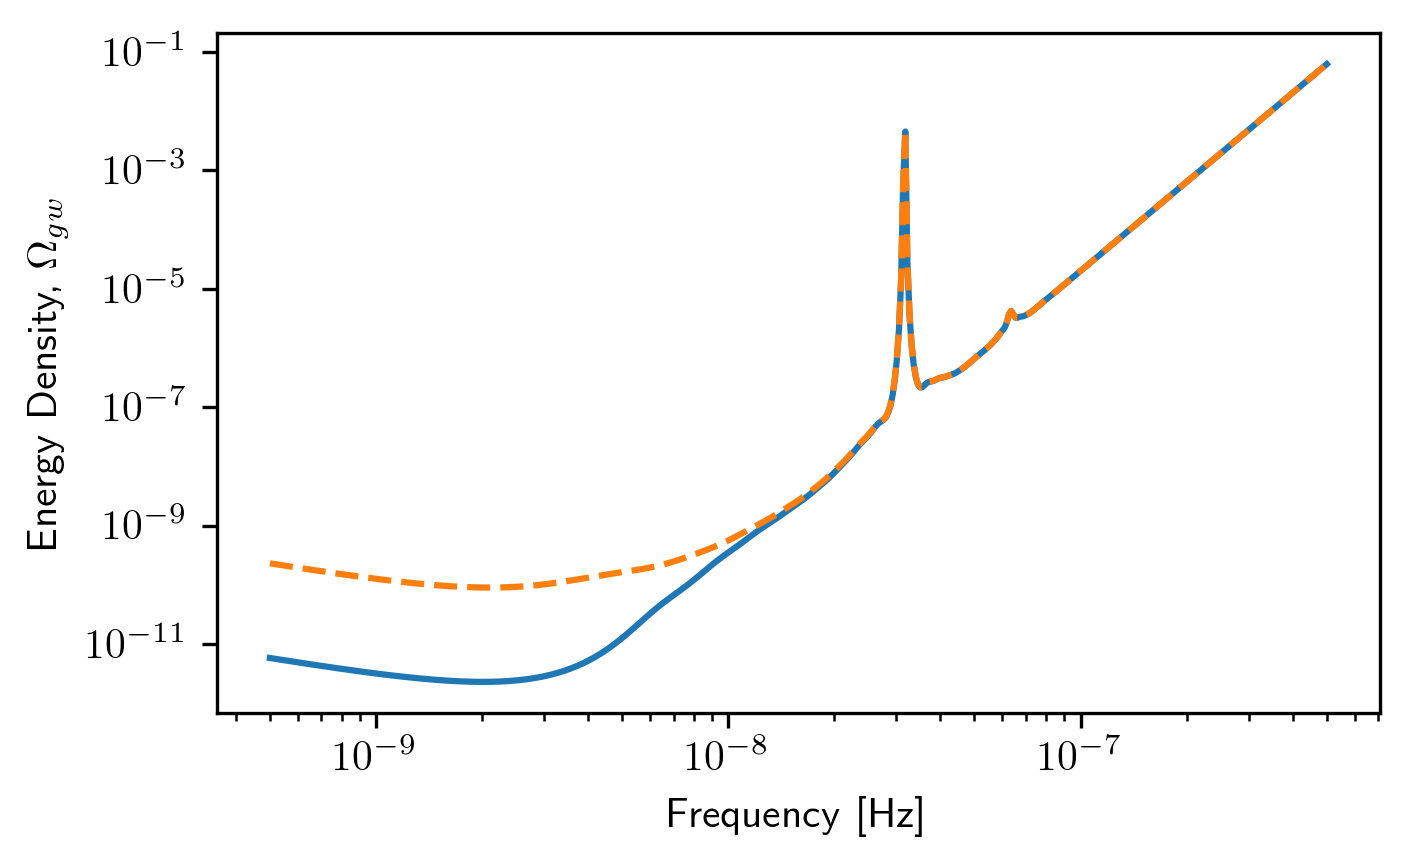

In [17]:
plt.loglog(sc1a.freqs,sc1a.Omega_gw)
plt.loglog(sc2a.freqs,sc2a.Omega_gw,'--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Energy Density, $\Omega_{gw}$')
plt.show()

In [29]:
#BHB params
m1=1.2e9
m2=7e8
M_c=(m1*m2)**(3./5)/(m1+m2)**(1./5)
z = 0.0213
DL = 85.8
f_0 =60.4*u.nHz.to('Hz')

f_array = np.array([1.,5.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.])*u.nHz.to('Hz')
DL_array = np.array([1.,5.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.])
M_c_array = np.array([1.,5.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.])*1e9
h_0_circ_array = []
SNR_array_sc1b = []
SNR_array_sc2b = []
for i in range(len(f_array)):
    h_0_circ = hsky.h0_circ(M_c_array[i],DL_array[i],f_array[i])
    h_0_circ_array.append(h_0_circ.to(''))
    SNR_array_sc1b.append(sc1b.SNR(h_0_circ,f_array[i]))
    SNR_array_sc2b.append(sc2b.SNR(h_0_circ,f_array[i]))

In [94]:
def S_h_circ(M_c,D_L,f0,Tspan,f):
    h0 = hsky.h0_circ(M_c, D_L, f0)
    h0 = h0.to('').value
    S_h = .5 * h0**2 * Tspan * (np.sinc(Tspan*(f-f0)) 
                                                     + np.sinc(Tspan*(f+f0)))
    return S_h

In [95]:
def SNR_calc(freqs,Tspan,S_eff,Sh):
    integrand = Sh**2 / S_eff**2
    SNR = np.sqrt(2.0 * Tspan * np.trapz(y=integrand,
                                               x=freqs,
                                               axis=0))
    return SNR

In [96]:
S_h_circ_sc1b_array = []
S_h_circ_sc2b_array = []
SNR_array_sc1b_2 = []
SNR_array_sc2b_2 = []
for i in range(len(f_array)):
    S_h_circ_sc1b = S_h_circ(M_c_array[i],DL_array[i],f_array[i],sc1b.Tspan,sc1b.freqs)
    S_h_circ_sc2b = S_h_circ(M_c_array[i],DL_array[i],f_array[i],sc2b.Tspan,sc2b.freqs)
    S_h_circ_sc1b_array.append(S_h_circ_sc1b)
    S_h_circ_sc2b_array.append(S_h_circ_sc2b)
    SNR_array_sc1b_2.append(SNR_calc(sc1b.freqs,sc1b.Tspan,sc1b.S_eff,S_h_circ_sc1b))
    SNR_array_sc2b_2.append(SNR_calc(sc1b.freqs,sc2b.Tspan,sc2b.S_eff,S_h_circ_sc2b))

In [89]:
save_dir = '/Users/andrewkaiser/Documents/GradSchool/Research/nanograv/Figures/'

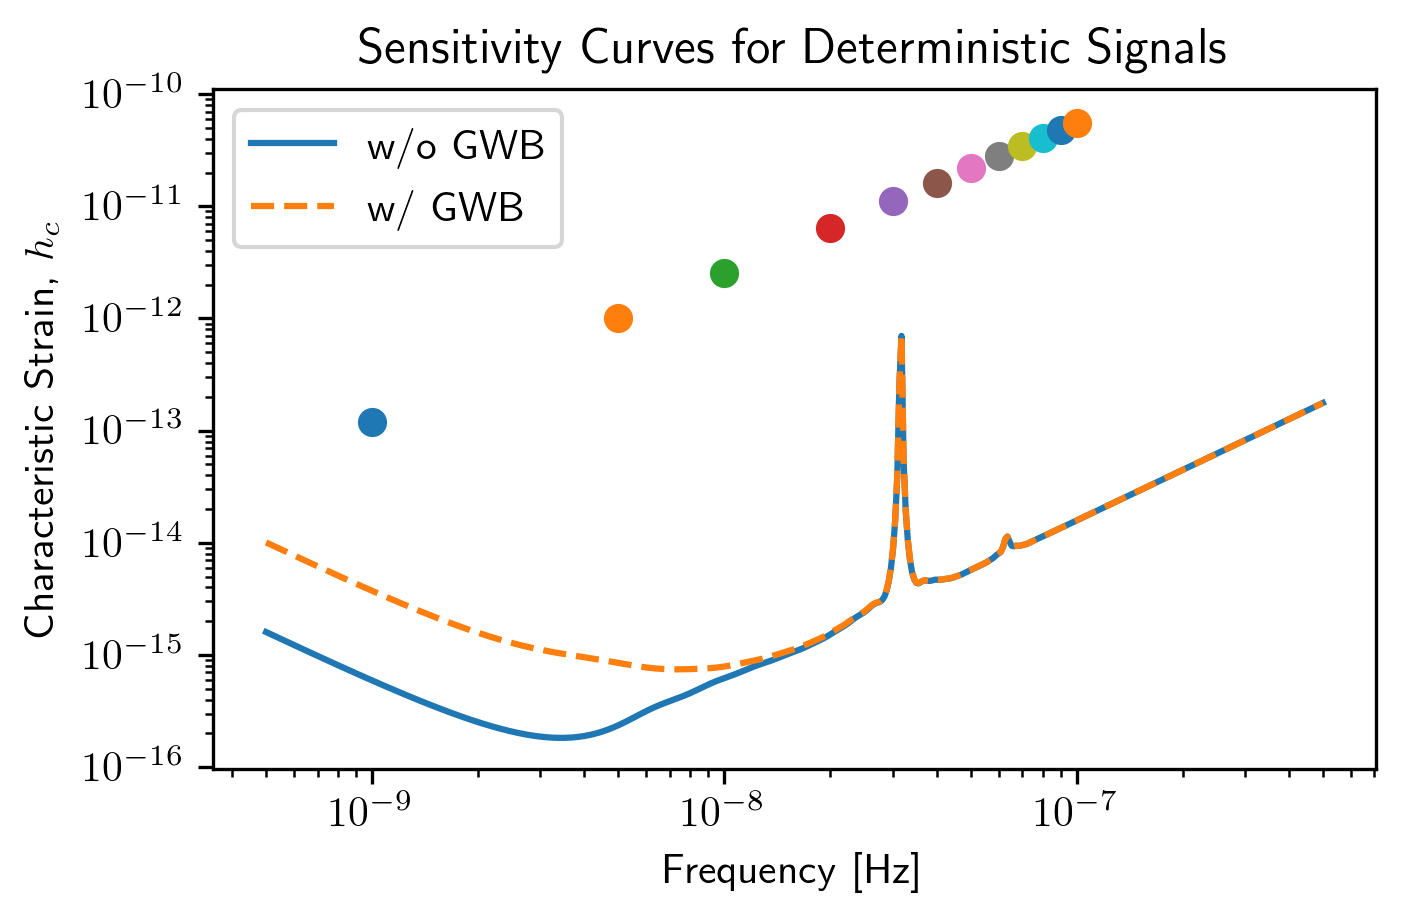

In [90]:
plt.loglog(sc1b.freqs,sc1b.h_c,label='w/o GWB')
plt.loglog(sc2b.freqs,sc2b.h_c,'--',label='w/ GWB')
for i in range(len(f_array)):
    plt.scatter(f_array[i],h_0_circ_array[i])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('Sensitivity Curves for Deterministic Signals')
plt.legend()
#plt.savefig(save_dir+'deter_sens_SNR_curves.png', bbox_inches='tight')
plt.show()

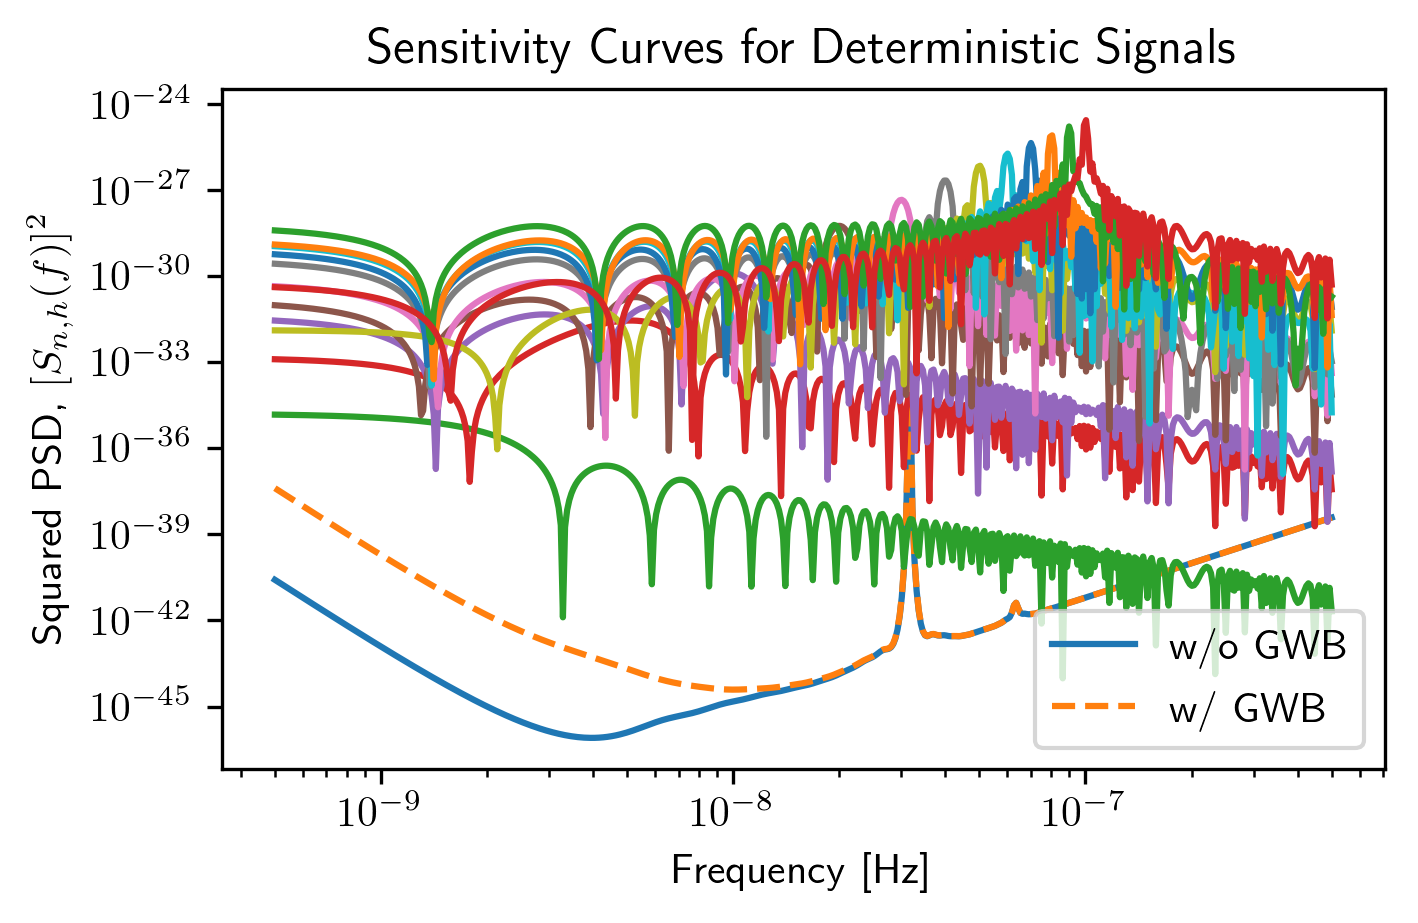

In [102]:
plt.loglog(sc1b.freqs,sc1b.S_eff**2,label='w/o GWB')
plt.loglog(sc2b.freqs,sc2b.S_eff**2,'--',label='w/ GWB')
for i in range(len(f_array)):
    plt.loglog(sc1b.freqs,S_h_circ_sc1b_array[i]**2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Squared PSD, $[S_{n,h}(f)]^{2}$')
plt.title('Sensitivity Curves for Deterministic Signals')
plt.legend()
#plt.savefig(save_dir+'deter_sens_SNR_curves.png', bbox_inches='tight')
plt.show()

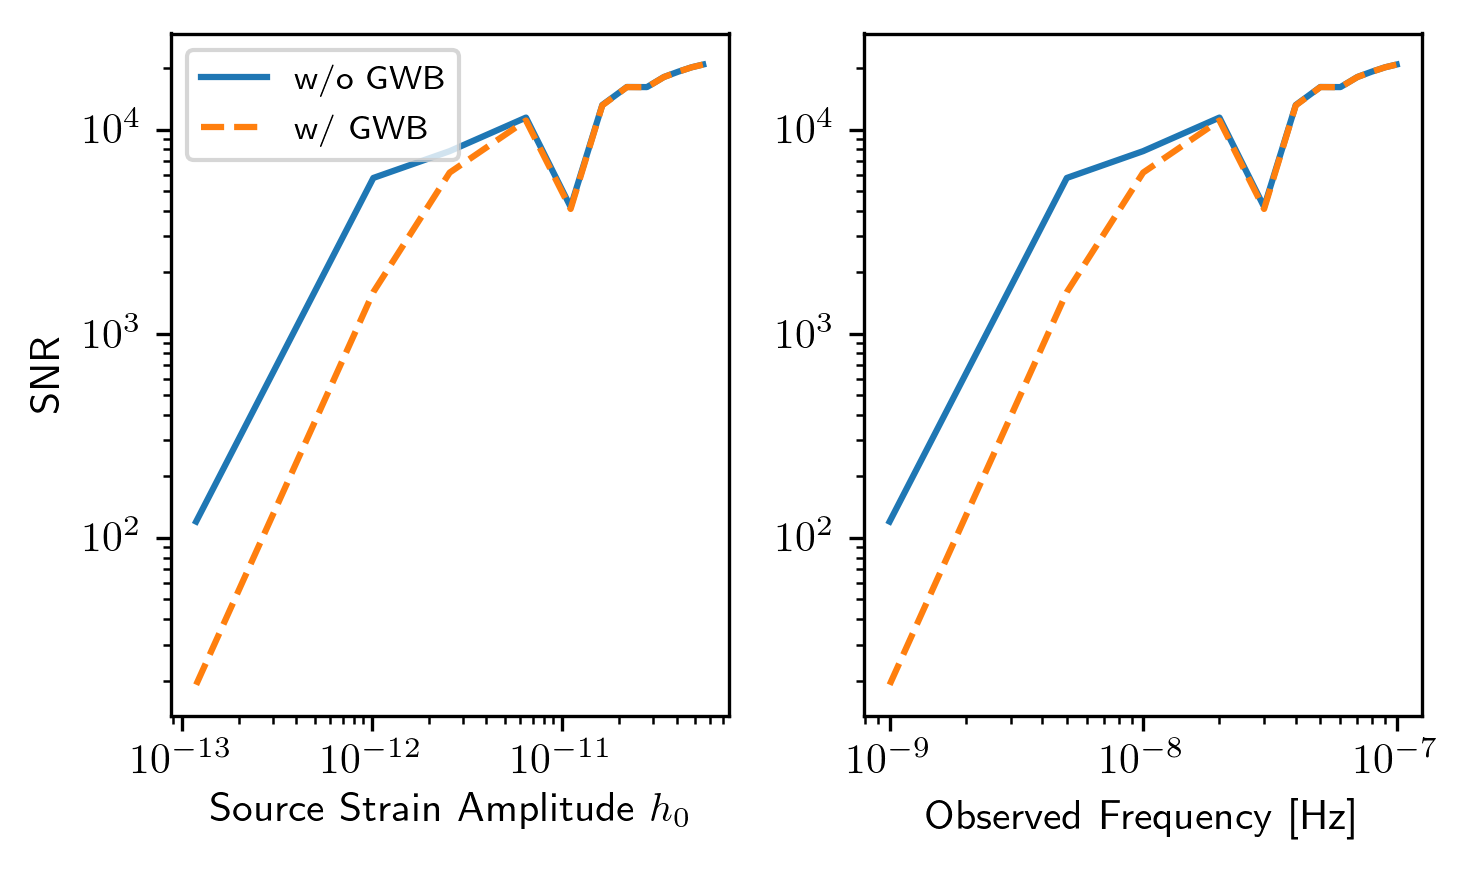

In [98]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.loglog(h_0_circ_array,SNR_array_sc1b,label='w/o GWB')
ax1.loglog(h_0_circ_array,SNR_array_sc2b,'--',label='w/ GWB')
ax1.set_xlabel(r'Source Strain Amplitude $h_{0}$')
ax1.set_ylabel(r'SNR')
ax2.loglog(f_array,SNR_array_sc1b)
ax2.loglog(f_array,SNR_array_sc2b,'--')
ax2.set_xlabel(r'Observed~Frequency [Hz]')
ax1.legend(loc='upper left',fontsize=8)
fig.tight_layout()
#plt.savefig(save_dir+'deter_SNR_curves.png', bbox_inches='tight')
plt.show()

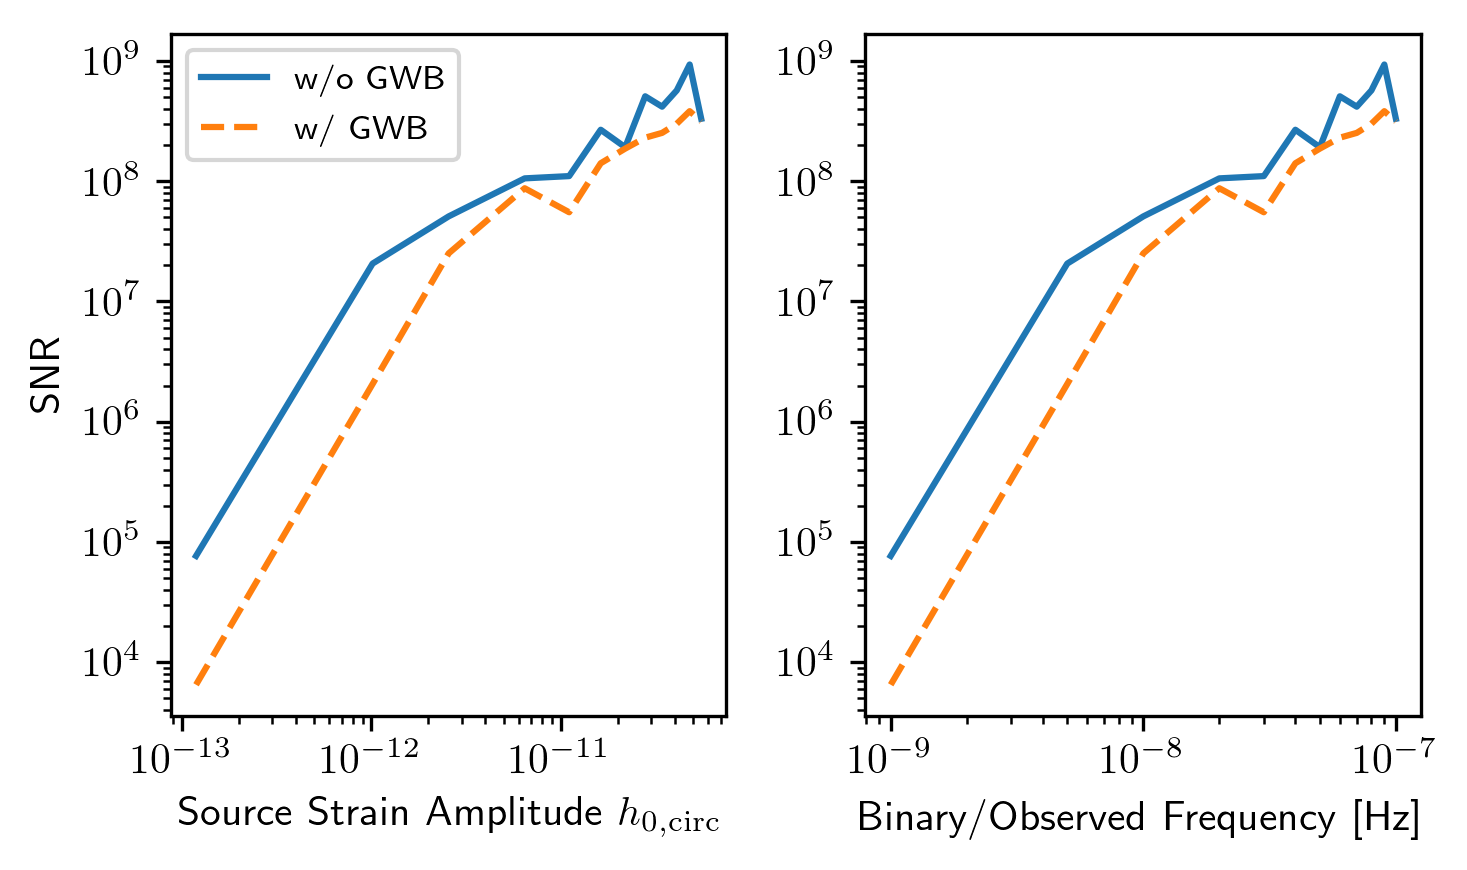

In [99]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.loglog(h_0_circ_array,SNR_array_sc1b_2,label='w/o GWB')
ax1.loglog(h_0_circ_array,SNR_array_sc2b_2,'--',label='w/ GWB')
ax1.set_xlabel(r'Source Strain Amplitude $h_{0,\mathrm{circ}}$')
ax1.set_ylabel(r'SNR')
ax2.loglog(f_array,SNR_array_sc1b_2)
ax2.loglog(f_array,SNR_array_sc2b_2,'--')
ax2.set_xlabel(r'Binary/Observed~Frequency [Hz]')
ax1.legend(loc='upper left',fontsize=8)
fig.tight_layout()
#plt.savefig(save_dir+'deter_SNR_curves.png', bbox_inches='tight')
plt.show()

## Multiple Values for Red Noise
One can give each pulsar its own value for the red noise power spectrum. 

In [22]:
A_rn = np.random.uniform(1e-16,1e-12,size=phi.shape[0])
alphas = np.random.uniform(-3/4,1,size=phi.shape[0])

psrs3 = hsim.sim_pta(timespan=timespan,cad=23,sigma=1e-7,
                     phi=phi,theta=theta,
                     A_rn=A_rn,alpha=alphas,freqs=freqs)

spectra3 = []
for p in psrs3:
    sp = hsen.Spectrum(p, freqs=freqs)        
    sp.NcalInv
    spectra3.append(sp)

sc3a=hsen.GWBSensitivityCurve(spectra3)
sc3b=hsen.DeterSensitivityCurve(spectra3)

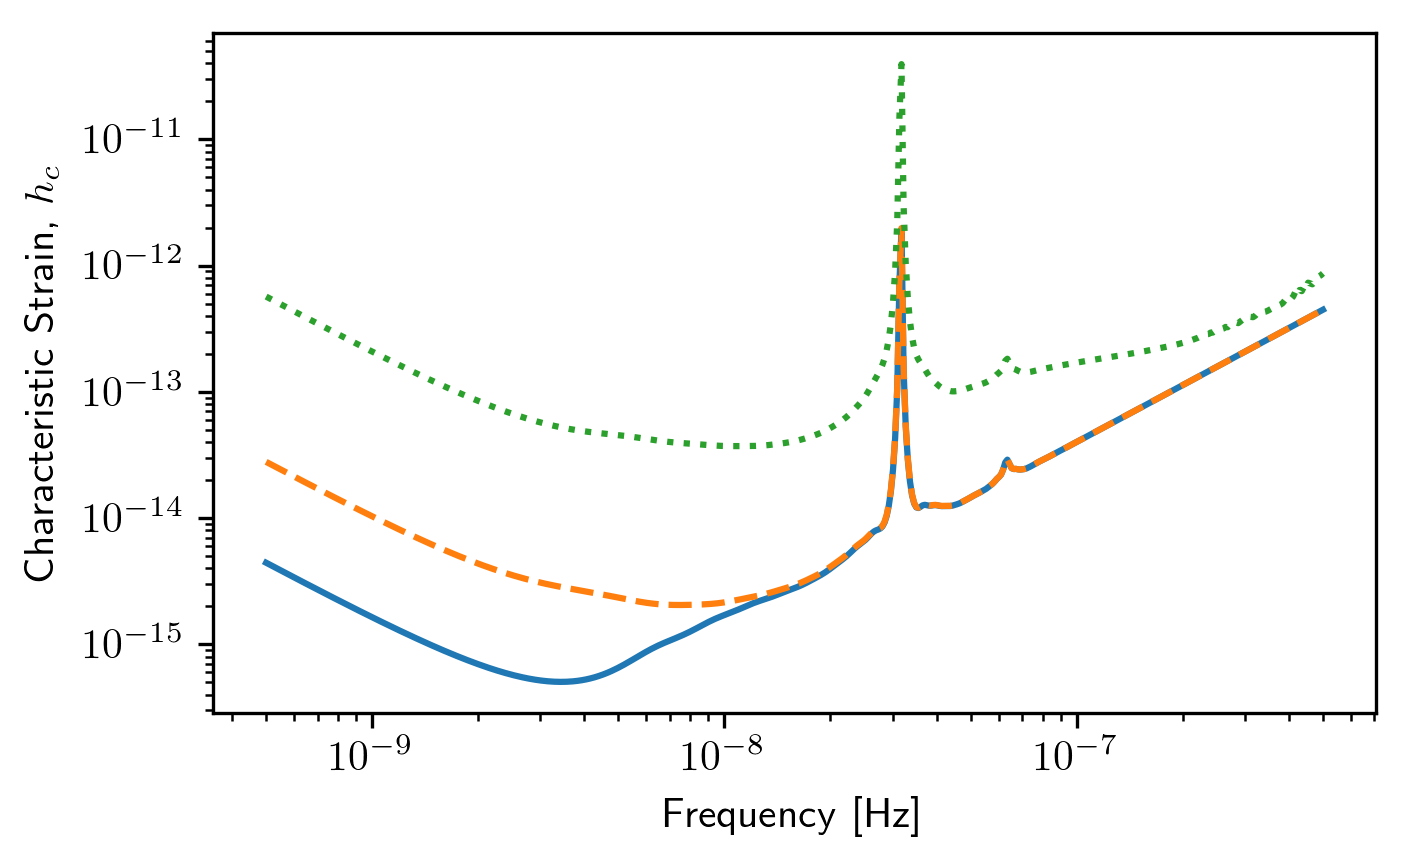

In [23]:
plt.loglog(sc1a.freqs,sc1a.h_c)
plt.loglog(sc2a.freqs,sc2a.h_c,'--')
plt.loglog(sc3a.freqs,sc3a.h_c,':')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

## Power Law-Integrated Sensitivity Curves
There are a few additional functions in the `hasasia.senstivity` module for calculating a power law-integrated noise curve for stochastic senstivity curves.

First we use the `Agwb_from_Seff_plaw` method to calculate the amplitude of a GWB needed to obtain an SNR=3 with the usual spectral index, which is the default value of the spectral index.

In [24]:
hgw = hsen.Agwb_from_Seff_plaw(sc1a.freqs, Tspan=sc1a.Tspan, SNR=3,
                               S_eff=sc1a.S_eff)

#We calculate the power law across the frequency range for plotting.
fyr = 1/(365.25*24*3600)
plaw_h = hgw*(sc1a.freqs/fyr)**(-2/3)

The `Agwb_from_Seff_plaw` is used by the `PI_hc` method to conveniently calculate the power law-integrated sensitivity across a frequency range of the user's choice. The method returns the PI sensitivity curve and the set of power law values solved for in the process. 

In [25]:
PI_sc, plaw = hsen.PI_hc(freqs=sc1a.freqs, Tspan=sc1a.Tspan,
                         SNR=3, S_eff=sc1a.S_eff, N=30)

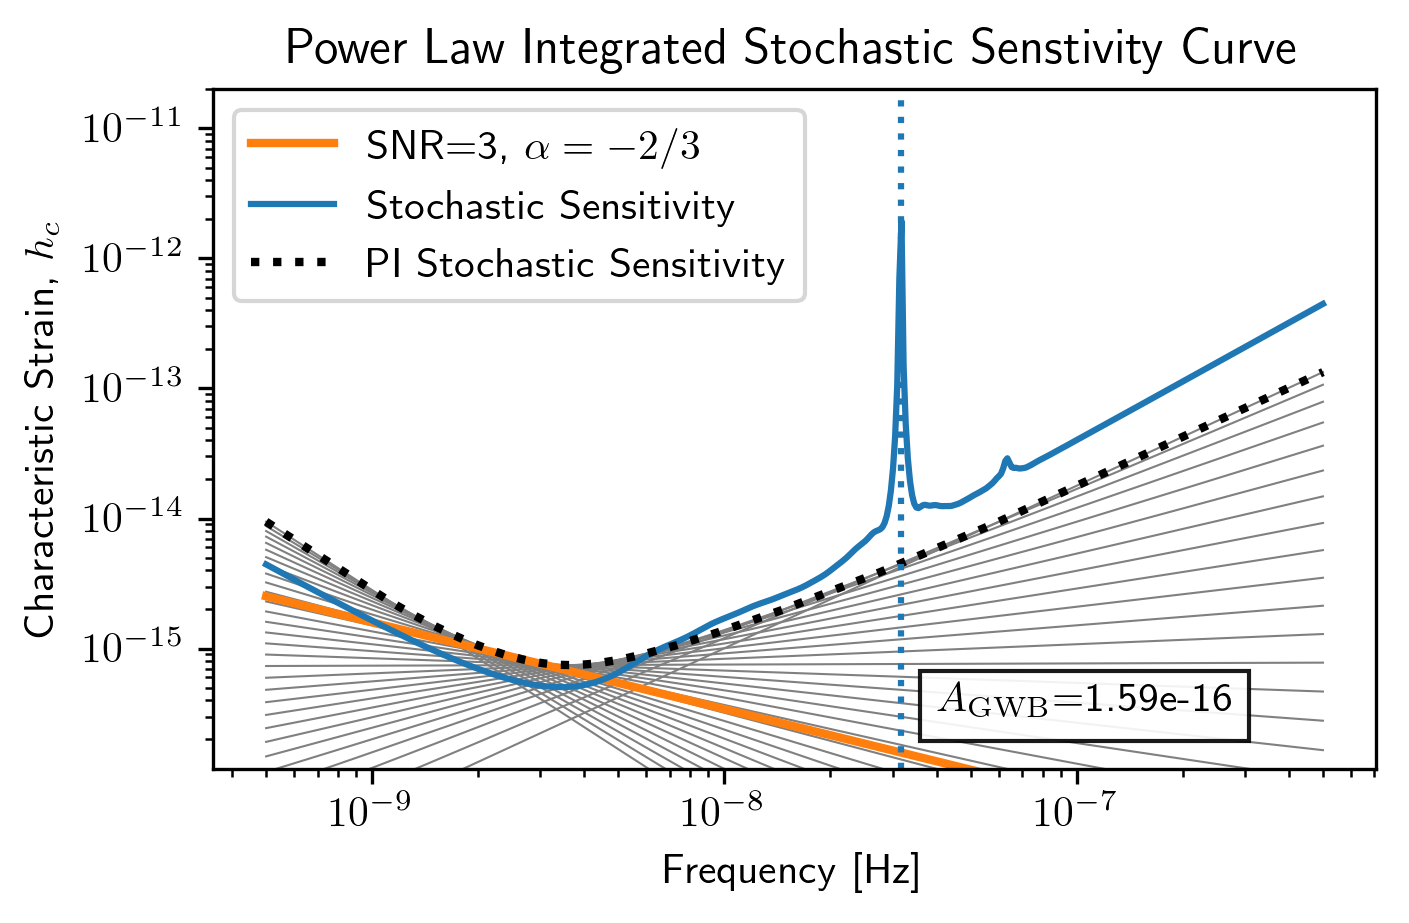

In [26]:
for ii in range(plaw.shape[1]):
    plt.loglog(sc1a.freqs,plaw[:,ii],
               color='gray',lw=0.5)
plt.loglog(sc1a.freqs,plaw_h,color='C1',lw=2,
           label=r'SNR=3, $\alpha=-2/3$')  
plt.loglog(sc1a.freqs,sc1a.h_c, label='Stochastic Sensitivity')
plt.loglog(sc1a.freqs,PI_sc, linestyle=':',color='k',lw=2,
           label='PI Stochastic Sensitivity')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.axvline(fyr,linestyle=':')
plt.title('Power Law Integrated Stochastic Senstivity Curve')
plt.ylim(hgw*0.75,2e-11)
plt.text(x=4e-8,y=3e-16,
         s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw),
         bbox=dict(facecolor='white', alpha=0.9))
plt.legend(loc='upper left')
plt.show()

Here we see a fairly optimistic sensitivity at the SNR=3 threshold since this PTA is made up of 100 ns-precision pulsars with no red noise. 

## Pairwise Senstivity Curves
One can also access each term of the series in the calculation of the stochastic effective sensitivity curve. Each unique pair is available in the `GWBSensitivity.S_effIJ` attribute. The pulsars can be identified using the `GWBSensitivity.pairs` attribute.

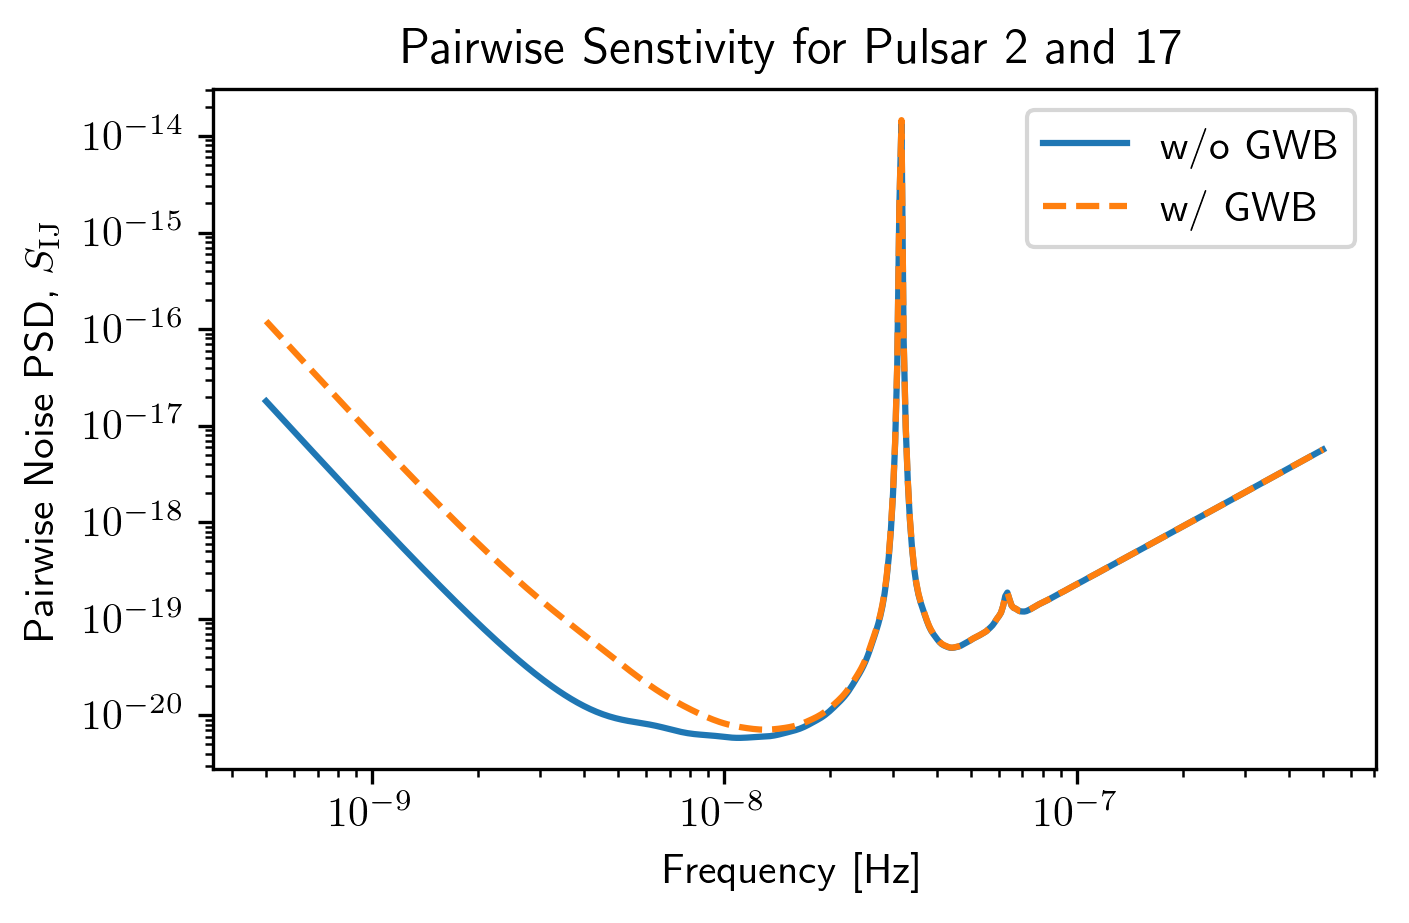

In [27]:
plt.loglog(sc1a.freqs,sc1a.S_effIJ[79],label='w/o GWB')
plt.loglog(sc2a.freqs,sc2a.S_effIJ[79],'--',label='w/ GWB')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Pairwise Noise PSD, $S_{\rm IJ}$')
p1,p2 = sc1a.pairs[:,79]
plt.title(r'Pairwise Senstivity for Pulsar {0} and {1}'.format(p1,p2))
plt.legend()
plt.show()